# Coursework 1: Convolutional Neural Networks
### Autograding
Part 1 of this coursework is autograded. This notebook comes with embedded tests which will verify that your implementations provide outputs with the appropriate types and shapes required for our hidden tests. You can run these same public tests through [LabTS](https://teaching.doc.ic.ac.uk/labts) when you have finished your work, to check that we get the same results when running these public tests.

Hidden tests will be ran after the submission deadline, and cannot be accessed :)

### Setting up working environment

For this coursework you will need to train a large network, therefore we recommend you work with Google Colaboratory or Lab cluster, where you can access GPUs.

Please refer to the Intro lecture for getting set up on the various GPU options.

**To run the public tests within colab** you will need to copy the "tests" folder to the /content/ directory (this is the default working directory - you can also change directories with %cd). You may also need to place a copy of the CW ipynb in the /content/ directory. A better option is to mount colab on gdrive and keep the files there (so you only need to do the set up once).

#### Setup
You will need to install pytorch and other libraries by running the following cell:

<font color="orange">**The deadline for submission is Tuesday, 6 Feb by 6 pm** </font>

In [1]:
!pip install -q otter-grader pandoc torch torchvision scikit-learn seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.5/159.5 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.1/160.1 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.7/152.7 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.0/127.0 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Initialization Cell
try:
    WORKING_ENV = 'COLAB' # Can be LABS, COLAB, PAPERSPACE, SAGEMAKER
    USERNAME = 'your_username' # If working on Lab Machines - Your college username
    assert WORKING_ENV in ['LABS', 'COLAB', 'PAPERSPACE', 'SAGEMAKER']

    if WORKING_ENV == 'COLAB':
        from google.colab import drive
        %load_ext google.colab.data_table
        d1_cw1_repo_path = '' # path in your gdrive to the repo
        content_path = f'/content/drive/MyDrive/{d1_cw1_repo_path}' # path to gitrepo in gdrive after mounting
        drive.mount('/content/drive/') # Outputs will be saved in your google drive

    elif WORKING_ENV == 'LABS':
        content_path = f'/vol/bitbucket/{USERNAME}/dl/dl_cw1/' # You may want to change this
        # Your python env and training data should be on bitbucket
        if 'vol' not in content_path:
            import warnings
            warnings.warn(
                'It is best to create a dir in /vol/bitbucket/ otherwise you will quickly run into memory issues'
            )

    elif WORKING_ENV == 'PAPERSPACE': # Using Paperspace
        # Paperspace does not properly render animated progress bars
        # Strongly recommend using the JupyterLab UI instead of theirs
        !pip install ipywidgets
        content_path = '/notebooks'

    elif WORKING_ENV == 'SAGEMAKER':
        content_path = '/home/studio-lab-user/sagemaker-studiolab-notebooks/'
    else:
        raise NotImplementedError()

    import otter
    import os
    if not os.path.exists(f'{content_path}tests'):
        raise ValueError('Cannot find the public tests folder')
    grader = otter.Notebook(
        f'{content_path}dl_cw_1.ipynb',
        tests_dir=f'{content_path}tests')
    import matplotlib.pyplot as plt # DO NOT use %matplotlib inline in the notebook
    import numpy as np
    rng_seed = 90
except:
    # This is a fallback initialization for running on LabTS. Please leave this in place before submission.
    import otter
    grader = otter.Notebook("dl_cw_1.ipynb")
    import matplotlib.pyplot as plt
    import numpy as np
    rng_seed = 90


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Introduction
In this courswork you will explore various deep learning functionalities through implementing a number of pytorch neural network operations/layers and creating your own deep learning model and methodology for a high dimensional classification problem.

#### Intended learning outcomes
- An understanding of the mechanics behind convolutional, pooling, linear and batch norm operations.
- Be able to implement convolution, pooling, linear and batch norm layers from basic building blocks.
- Experience designing, implementing and optimising a classifier for a high dimensional dataset.

## Part 1 (50 points)

In this part, you will use basic Pytorch operations to define the 2D convolution, 2D max pooling, linear layer, as well as 2D batch normalization operations. Being computer scientists we care about efficiency, we therefore do not want to see any _for loops_!

**Your Task**
- Implement the forward pass for Conv2D (15 points), MaxPool2D (15 points), Linear (5 points) and BatchNorm2d (15 points)
- You are **NOT** allowed to use the torch.nn modules (The one exception is that the class inherits from nn.Module)

_hint: check out F.unfold and F.fold, they may be helpful_

In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class Conv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 bias=True):

        super(Conv2d, self).__init__()
        """
        An implementation of a convolutional layer.

        The input consists of N data points, each with C channels, height H and
        width W. We convolve each input with F different filters, where each filter
        spans all C channels and has height H' and width W'.

        Parameters:
        - w: Filter weights of shape (F, C, H', W',)
        - b: Biases of shape (F,)
        - kernel_size: Union[int, (int, int)], Size of the convolving kernel
        - stride: Union[int, (int, int)], Number of pixels between adjacent receptive fields in the
            horizontal and vertical directions.
        - padding: Union[int, (int, int)], Number of pixels that will be used to zero-pad the input.
        """
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # TODO: Define the parameters used in the forward pass

        # self.in_channels = in_channels
        # self.out_channels = out_channels
        self.F = out_channels
        self.C = in_channels

        #checks whether kernel_size is an instance of int
        self.kernel_size = (kernel_size, kernel_size) if isinstance(kernel_size, int) else kernel_size
        # self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        # Do not initialize weights or biases with torch.empty() but rather use torch.zeros()
        # Weights should have shape [out_channels, in_channels, kernel_x, kernel_y]
        #
        # self.w = nn.Parameter(torch.randn(out_channels, in_channels, *self.kernel_size) * math.sqrt(2. / in_channels))
        # w = torch.randn(out_channels, in_channels, kernel_size, kernel_size) * math.sqrt(2. / in_channels)

        # self.w = nn.Parameter(w)
        # if type(kernel_size) == int:
        #   self.w = torch.zeros(self.F, self.C, kernel_size, kernel_size)
        # else:
        #   self.w = torch.zeros(self.F, self.C, kernel_size[0], kernel_size[1])

        kernel_dim = (kernel_size, kernel_size) if isinstance(kernel_size, int) else kernel_size
        self.w = torch.zeros(self.F, self.C, *kernel_dim)
        # self.b = nn.Parameter(torch.zeros(out_channels))

        # Ensure the kernel size is properly handled if it's an int or a tuple

        # Bias should have shape [out_channels]

        # Simplify the initialization of weights `self.w`


        # Simplify the initialization of bias `self.b`
        self.b = torch.zeros(self.F) if bias else None

        # if bias:
        #     self.b = nn.Parameter(torch.zeros(out_channels))
        # else:
        #     self.register_parameter('bias', None)  # Explicitly register bias as None if not used
        # Bias should have shape [out_channels]
        # if bias:
        #   self.b = torch.zeros(self.F)
        # else:
        #   self.b = None
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, F, H', W').
        """
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # TODO: Implement the forward pass                                     #
        # Calculate the dimensions of the output based on the convolution parameters
        # Calculate the output dimensions.
        N, C, H, W = x.size()

      # with both int and tuple inputs for stride, kernel_size, and padding.

        stride_x, stride_y = (self.stride, self.stride) if isinstance(self.stride, int) else self.stride

        kernel_x, kernel_y = (self.kernel_size, self.kernel_size) if isinstance(self.kernel_size, int) else self.kernel_size

        padding_x, padding_y = (self.padding, self.padding) if isinstance(self.padding, int) else self.padding



        # H_out = math.floor(((H + 2 * self.padding[0] - self.kernel_size[0]) / self.stride[0] + 1))
        # W_out = math.floor(((W + 2 * self.padding[1] - self.kernel_size[1]) / self.stride[1] + 1))


        H_out =  math.floor(((H + 2 * padding_x - kernel_x ) / stride_x + 1))
        W_out =  math.floor(((W + 2 * padding_y - kernel_y ) / stride_y + 1))



        # Apply padding
        # x_padded = F.pad(x, (self.padding, self.padding, self.padding, self.padding))

        # Perform the convolution using F.unfold and F.fold for efficiency
        # Unfold the input
        x_unfolded = F.unfold(x, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)
        # Matrix multiplication between unfolded input and weights, then add bias
        out_unfolded = x_unfolded.transpose(1, 2).matmul(self.w.view(self.w.size(0), -1).t()).transpose(1, 2)


        out = F.fold(out_unfolded, (H_out, W_out), (1, 1))

        if self.b is not None:
            out += self.b.view(-1,self.F,1, 1)
        # Fold back to get the output tensor




        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out

In [61]:
grader.check("Convolution Layer")

Convolution Layer results: All test cases passed!
Convolution Layer - 1 message: Shape Test Passed
Convolution Layer - 2 message: Type Test Passed
Convolution Layer - 3 message: Param Name Test Passed
Convolution Layer - 4 message: Param Shape Test Passed

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MaxPool2d(nn.Module):
    def __init__(self, kernel_size):
        super(MaxPool2d, self).__init__()
        """
        An implementation of a max-pooling layer.

        Parameters:
        - kernel_size: Union[int, (int, int)], the size of the window to take a max over
        """
        # TODO: Define the parameters used in the forward pass                 #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # Initialize parameters
        self.kernel_size = kernel_size
        self.stride = kernel_size  # generally, stride is set equal to kernel size in max pooling
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, C, H', W').
        """
        # TODO: Implement the forward pass                                     #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


        N, C, H, W = x.shape
        # Calculate output dimensions
        H_out = (H - self.kernel_size) // self.stride + 1
        W_out = (W - self.kernel_size) // self.stride + 1

        # Padding is not considered in this simple implementation
        # Unfold the input in both dimensions
        unfolded_x = F.unfold(x, kernel_size=self.kernel_size, stride=self.stride)

        # unfolded_x has shape (N, C*K*K, L), where L is the total number of sliding windows
        # and K*K is the unfolding (flattening) of the kernel over each window
        # We need to reshape it to (N, C, K*K, L), then take max over dim=2 (the flattened kernel dimensions)
        unfolded_x = unfolded_x.view(N, C, self.kernel_size*self.kernel_size, -1)

        # Now take the max over the kernel dimension
        pooled, _ = unfolded_x.max(dim=2)

        # Reshape to the output shape: (N, C, H_out, W_out)
        out = pooled.view(N, C, H_out, W_out)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out


In [7]:
grader.check("MaxPool Layer")

MaxPool Layer results: All test cases passed!
MaxPool Layer - 1 message: Shape Test Passed
MaxPool Layer - 2 message: Type Test Passed

In [8]:
class Linear(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True):
        super(Linear, self).__init__()
        """
        An implementation of a Linear layer.

        Parameters:
        - weight: the learnable weights of the module of shape (in_channels, out_channels).
        - bias: the learnable bias of the module of shape (out_channels).
        """
        # TODO: Define the parameters used in the forward pass                 #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # self.register_parameter is not used as it was mentioned on piazza
        # that this will be overridden
        # Also no initialisation methods for this reason
        # Initialize weights with a standard initialization method
        # Shape of weight matrix: (out_channels, in_channels)
        self.w = nn.Parameter(torch.randn(out_channels, in_channels) * 0.01)

        # Initialize bias if it is required
        if bias:
            # Shape of bias: (out_channels)
            self.b = nn.Parameter(torch.zeros(out_channels))
        else:
            self.b = None  # It's important to handle the case where no bias is wanted

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, *, H) where * means any number of additional
        dimensions and H = in_channels
        Output:
        - out: Output data of shape (N, *, H') where * means any number of additional
        dimensions and H' = out_channels
        """
        # TODO: Implement the forward pass                                     #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Calculate the linear transformation
        # x shape: (N, *, in_channels), w shape: (out_channels, in_channels)
        # For matrix multiplication, we use torch.matmul which handles the batch dimensions (*) properly
        out = torch.matmul(x, self.w.t())  # Transpose w to match the shape requirements for matmul

        # Add bias if it's not None
        if self.b is not None:
            out += self.b

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out

In [9]:
grader.check("Linear Layer")

Linear Layer results: All test cases passed!
Linear Layer - 1 message: Shape Test Passed
Linear Layer - 2 message: Type Test Passed
Linear Layer - 3 message: Param Name Test Passed
Linear Layer - 4 message: Param Shape Test Passed

In [10]:
class BatchNorm2d(nn.Module):
	def __init__(self, num_features, eps=1e-05, momentum=0.1):
		super(BatchNorm2d, self).__init__()
		"""
		An implementation of a Batch Normalization over a mini-batch of 2D inputs.

		The mean and standard-deviation are calculated per-dimension over the
		mini-batches and gamma and beta are learnable parameter vectors of
		size num_features.

		Parameters:
		- num_features: C from an expected input of size (N, C, H, W).
		- eps: a value added to the denominator for numerical stability. Default: 1e-5
		- momentum: the value used for the running_mean and running_var
		computation. Default: 0.1 . (i.e. 1-momentum for running mean)
		- gamma: the learnable weights of shape (num_features).
		- beta: the learnable bias of the module of shape (num_features).
		"""
		# TODO: Define the parameters used in the forward pass                 #
		# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
		self.num_features = num_features
		self.eps = eps
		self.momentum = momentum

		# Learnable parameters
		self.gamma = nn.Parameter(torch.ones(num_features))
		self.beta = nn.Parameter(torch.zeros(num_features))

		# Running mean and variance for use during inference
		# Not learnable parameters, so we use buffers
		self.register_buffer('running_mean', torch.zeros(num_features))
		self.register_buffer('running_var', torch.ones(num_features))

		# Initialize running estimates
		self.running_mean.zero_()
		self.running_var.fill_(1)
		self.training = True
		# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

	def forward(self, x):
		"""
		During training this layer keeps running estimates of its computed mean and
		variance, which are then used for normalization during evaluation.
		Input:
		- x: Input data of shape (N, C, H, W)
		Output:
		- out: Output data of shape (N, C, H, W) (same shape as input)
		"""
		# TODO: Implement the forward pass                                     #
		#       (be aware of the difference for training and testing)          #
		# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
		if self.training:
			# Calculate mean and variance for the batch
			batch_mean = x.mean([0, 2, 3], keepdim=True)
			batch_var = x.var([0, 2, 3], keepdim=True, unbiased=False)

			# Update running mean and variance
			self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * batch_mean.squeeze()
			self.running_var = self.momentum * self.running_var + (1 - self.momentum) * batch_var.squeeze()

			# Normalize the batch using batch statistics
			x_normalized = (x - batch_mean) / (batch_var + self.eps).sqrt()

		else:
			# Normalize using running estimates during inference
			x_normalized = (x - self.running_mean.view(1, self.num_features, 1, 1)) / \
											(self.running_var.view(1, self.num_features, 1, 1) + self.eps).sqrt()

		# Apply scale and shift (gamma and beta)
		out = self.gamma.view(1, self.num_features, 1, 1) * x_normalized + self.beta.view(1, self.num_features, 1, 1)

		# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
		return x

In [11]:
grader.check("BatchNorm Layer")

BatchNorm Layer results: All test cases passed!
BatchNorm Layer - 1 message: Shape Test Passed
BatchNorm Layer - 2 message: Type Test Passed
BatchNorm Layer - 3 message: Param Name Test Passed
BatchNorm Layer - 4 message: Param Shape Test Passed

## Part 2 (40 points)

In this part, you will design, train and optimise a custom deep learning model for classifying a specially selected subset of Imagenet. Termed NaturalImageNet, it is made up of a hand selected subset of the famous ImageNet dataset. The dataset contains 20 classes, all animals from the natural world. We hope that this dataset will be fun to work with but also a challenge.

You will be marked on your experimental process, methods implemented and your reasoning behind your decisions. While there will be marks for exceeding a baseline performance score we stress that students should **NOT** spend excessive amounts of time optimising performance to silly levels.

We have given you some starter code, please feel free to use and adapt it.

**Your Task**
1. Develop/adapt a deep learning pipeline to maximise performance on the test set. (28 points)
    * 8 points will be awarded for improving on the baseline score on the test set. Don't worry you can get full marks here by improving by a minor amount.
    * 20 points will be awarded for the adaptations made to the baseline model and pipeline.

2. Answer the qualititative questions (12 points)

**Downloading NaturalImageNet**

In [12]:
ON_COLAB = False

!wget https://zenodo.org/record/5846979/files/NaturalImageNetTest.zip?download=1
!wget https://zenodo.org/record/5846979/files/NaturalImageNetTrain.zip?download=1
if ON_COLAB:
    !unzip /content/NaturalImageNetTest.zip?download=1 > /dev/null
    !unzip /content/NaturalImageNetTrain.zip?download=1 > /dev/null
else:
    !unzip NaturalImageNetTest.zip?download=1 > /dev/null
    !unzip NaturalImageNetTrain.zip?download=1 > /dev/null

--2024-02-06 14:48:50--  https://zenodo.org/record/5846979/files/NaturalImageNetTest.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.79.172, 188.184.103.159, 188.184.98.238, ...
Connecting to zenodo.org (zenodo.org)|188.185.79.172|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/5846979/files/NaturalImageNetTest.zip [following]
--2024-02-06 14:48:51--  https://zenodo.org/records/5846979/files/NaturalImageNetTest.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 138507970 (132M) [application/octet-stream]
Saving to: ‘NaturalImageNetTest.zip?download=1’

NaturalImageNetTest 100%[===================>] 132.09M  17.1MB/s    in 9.1s    

2024-02-06 14:49:01 (14.6 MB/s) - ‘NaturalImageNetTest.zip?download=1’ saved [138507970/138507970]

--2024-02-06 14:49:01--  https://zenodo.org/record/5846979/files/NaturalImageNetTrain.zip?download=1
Resolving zenodo.org (zenodo.org)... 188

In [40]:
#torch
import torch
from torch.nn import Conv2d, MaxPool2d
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
#other
import matplotlib.pyplot as plt
import numpy as np
# set the seed for reproducibility
rng_seed = 90
torch.manual_seed(rng_seed)

In [41]:
# When we import the images we want to first convert them to a tensor.
# It is also common in deep learning to normalise the the inputs. This
# helps with stability.
# To read more about this subject this article is a great one:
# https://towardsdatascience.com/understand-data-normalization-in-machine-learning-8ff3062101f0

# transforms is a useful pytorch package which contains a range of functions
# for preprocessing data, for example applying data augmentation to images
# (random rotations, blurring the image, randomly cropping the image). To find out
# more please refer to the pytorch documentation:
# https://pytorch.org/docs/stable/torchvision/transforms.html

mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])

#change
# Define transformations with aggressive data augmentation
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),  # Randomly resize and crop the image
    transforms.RandomHorizontalFlip(),  # Random horizontal flipping
    # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Random color jitter
    # # transforms.RandomApply([
    #     # transforms.GaussianBlur(3)  # Apply Gaussian Blur randomly
    # ], p=0.5),
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization
])

transform = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize(mean.tolist(), std.tolist()),
        ]
    )
train_path = ('/content/' if ON_COLAB else '') + 'NaturalImageNetTrain'
test_path = ('/content/' if ON_COLAB else '') +'NaturalImageNetTest'
#change
train_dataset = datasets.ImageFolder(train_path, transform=transform_train)
test_dataset = datasets.ImageFolder(test_path, transform=transform)

# Creating a train-validation split
n = len(train_dataset)
n_val = int(0.1 * n)  # 10% for validation
train_set, val_set = torch.utils.data.random_split(train_dataset, [n - n_val, n_val])

print(f"Training Set: {len(train_set)}, Validation Set: {len(val_set)}, Test Set: {len(test_dataset)}")

# DataLoader setup
batch_size = 256
#just for faster
num_workers = 8

loader_train = DataLoader(train_set, batch_size=batch_size, num_workers=num_workers, shuffle=True)
loader_val = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
loader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

Training Set: 17986, Validation Set: 1998, Test Set: 2000


In [42]:
unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

def denorm(x):
    '''
    Function to reverse the normalization so that we can visualise the outputs
    '''
    x = unnormalize(x)
    x = x.view(x.size(0), 3, 256, 256)
    return x

def show(img):
    '''
    function to visualise tensors
    '''
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)).clip(0, 1))

**Visualising some example images**

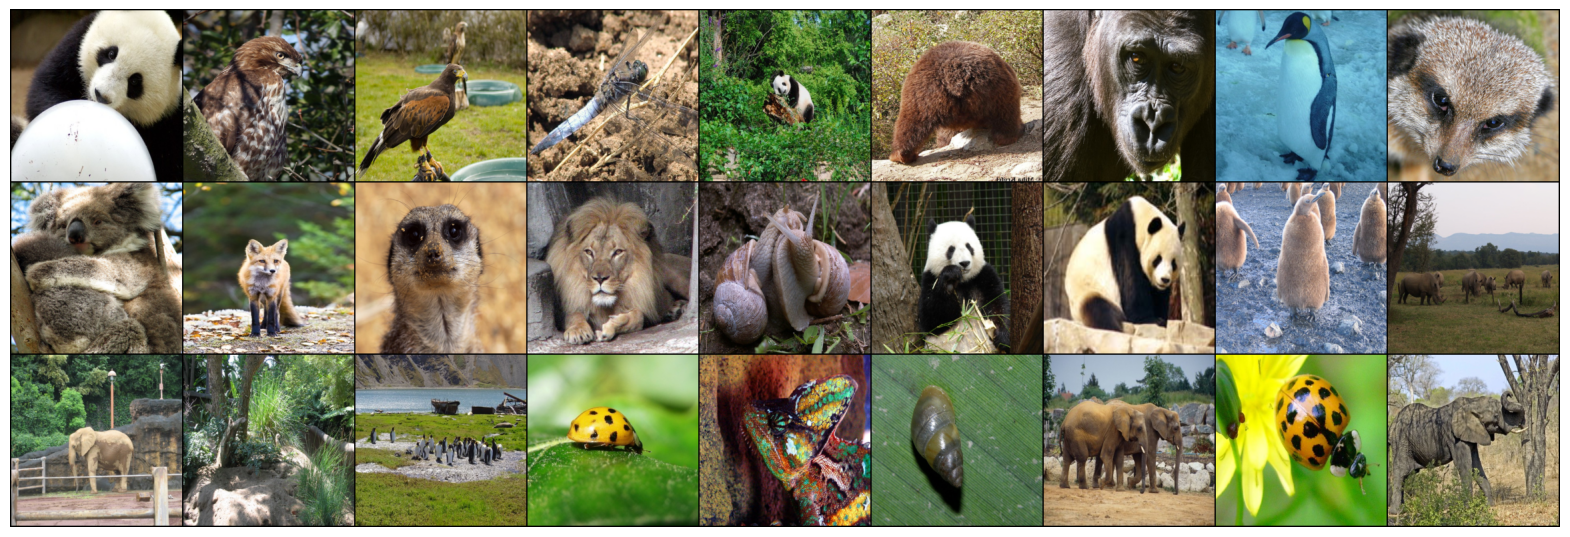

In [43]:
sample_inputs, _ = next(iter(loader_val))
fixed_input = sample_inputs[:27, :, :, :]

img = make_grid(denorm(fixed_input), nrow=9, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)
plt.figure(figsize=(20,10))
plt.axis('off')
show(img)

Next, we define ResNet-18:

In [44]:
# define resnet building blocks

class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):

        super(ResidualBlock, self).__init__()

        self.left = nn.Sequential(Conv2d(inchannel, outchannel, kernel_size=3,
                                         stride=stride, padding=1, bias=False),
                                  nn.BatchNorm2d(outchannel),
                                  nn.ReLU(inplace=True),
                                  Conv2d(outchannel, outchannel, kernel_size=3,
                                         stride=1, padding=1, bias=False),
                                  nn.BatchNorm2d(outchannel))

        self.shortcut = nn.Sequential()

        if stride != 1 or inchannel != outchannel:

            self.shortcut = nn.Sequential(Conv2d(inchannel, outchannel,
                                                 kernel_size=1, stride=stride,
                                                 padding = 0, bias=False),
                                          nn.BatchNorm2d(outchannel) )

    def forward(self, x):

        out = self.left(x)

        out += self.shortcut(x)

        out = F.relu(out)

        return out



# define resnet

class ResNet(nn.Module):

    def __init__(self, ResidualBlock, num_classes = 20):

        super(ResNet, self).__init__()
        #change 16->64
        self.inchannel = 64
        #change 16 to 64
        #change batchnorm2d 16 to 64
        #add maxpool2d 3
        self.conv1 = nn.Sequential(Conv2d(3, 64, kernel_size = 3, stride = 1,
                                  padding = 1, bias = False),
                                  nn.BatchNorm2d(64),
                                  nn.ReLU(),
                                  nn.MaxPool2d(3))
        #change 16 to 64,stride from 2 to 1
        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride = 1)
        #change 32 to 128
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride = 2)
        #change 64 to 256
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride = 2)
        #change 128 ti 512
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride = 2)
        # self.layer5 = self.make_layer(ResidualBlock, 256, 2, stride = 2)
        # self.layer6 = self.make_layer(ResidualBlock, 512, 2, stride = 2)
        self.maxpool = MaxPool2d(4)
        #add drop out
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(512, num_classes)
        #add - require specifying the output size directly
        #no matter the size of the input feature map, the output will be reduced to a 1x1 feature map
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        # Ensures output size of [batch_size, 512, 1, 1]


    def make_layer(self, block, channels, num_blocks, stride):

        strides = [stride] + [1] * (num_blocks - 1)

        layers = []

        for stride in strides:

            layers.append(block(self.inchannel, channels, stride))

            self.inchannel = channels

        return nn.Sequential(*layers)


    def forward(self, x):

        x = self.conv1(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # x = self.layer5(x)
        # x = self.layer6(x)
        #add
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        # add dropout
        x = self.dropout(x)
        x = self.fc(x)
        return x

# please do not change the name of this class
def MyResNet():
    return ResNet(ResidualBlock)

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


def confusion(preds, y):
  labels = ['African Elephant', 'Kingfisher', 'Deer','Brown Bear', 'Chameleon', 'Dragonfly',
    'Giant Panda', 'Gorilla', 'Hawk', 'King Penguin', 'Koala', 'Ladybug', 'Lion',
    'Meerkat', 'Orangutan', 'Peacock', 'Red Fox', 'Snail', 'Tiger', 'White Rhino']
  # Plotting the confusion matrix
  cm = confusion_matrix(y.cpu().numpy(), preds.cpu().numpy(), normalize='true')
  fig, ax= plt.subplots(1, 1, figsize=(15,10))
  sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
  ax.set_title('Confusion Matrix');
  ax.xaxis.set_ticklabels(labels, rotation = 70); ax.yaxis.set_ticklabels(labels, rotation=0);
  plt.show()

def incorrect_preds(preds, y, test_img):
  labels = ['African Elephant', 'Kingfisher', 'Deer','Brown Bear', 'Chameleon', 'Dragonfly',
    'Giant Panda', 'Gorilla', 'Hawk', 'King Penguin', 'Koala', 'Ladybug', 'Lion',
    'Meerkat', 'Orangutan', 'Peacock', 'Red Fox', 'Snail', 'Tiger', 'White Rhino']
  # lets see a sample of the images which were classified incorrectly!
  correct = (preds == y).float()
  test_labels_check = correct.cpu().numpy()
  incorrect_indexes = np.where(test_labels_check == 0)

  test_img = test_img.cpu()
  samples = make_grid(denorm(test_img[incorrect_indexes][:9]), nrow=3,
                      padding=2, normalize=False, value_range=None,
                      scale_each=False, pad_value=0)
  plt.figure(figsize = (20,10))
  plt.title('Incorrectly Classified Instances')
  show(samples)
  labels = np.asarray(labels)
  print('Predicted label',labels[preds[incorrect_indexes].cpu().numpy()[:9]])
  print('True label', labels[y[incorrect_indexes].cpu().numpy()[:9]])
  print('Corresponding images are shown below')

In [49]:


USE_GPU = True
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


print_every = 10
def check_accuracy(loader, model, analysis=False):
    # function for test accuracy on validation and test set

    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for t, (x, y) in enumerate(loader):
            x = x.to(device=device, dtype=dtype)  # move to device
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            if t == 0 and analysis:
              stack_labels = y
              stack_predicts = preds
            elif analysis:
              stack_labels = torch.cat([stack_labels, y], 0)
              stack_predicts = torch.cat([stack_predicts, preds], 0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct of val set (%.2f)' % (num_correct, num_samples, 100 * acc))
        if analysis:
          print('check acc', type(stack_predicts), type(stack_labels))
          confusion(stack_predicts, stack_labels)
          incorrect_preds(preds, y, x)
        return float(acc)



# def train_part(model, optimizer, epochs=1):
#     """
#     Train a model on NaturalImageNet using the PyTorch Module API.

#     Inputs:
#     - model: A PyTorch Module giving the model to train.
#     - optimizer: An Optimizer object we will use to train the model
#     - epochs: (Optional) A Python integer giving the number of epochs to train for

#     Returns: Nothing, but prints model accuracies during training.
#     """
#     model = model.to(device=device)  # move the model parameters to CPU/GPU
#     for e in range(epochs):
#         for t, (x, y) in enumerate(loader_train):
#             model.train()  # put model to training mode
#             x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
#             y = y.to(device=device, dtype=torch.long)

#             scores = model(x)
#             loss = F.cross_entropy(scores, y)

#             # Zero out all of the gradients for the variables which the optimizer
#             # will update.
#             optimizer.zero_grad()

#             loss.backward()

#             # Update the parameters of the model using the gradients
#             optimizer.step()



#             if t % print_every == 0:
#                 print('Epoch: %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
#         check_accuracy(loader_val, model)


In [20]:
# torch.cuda.empty_cache()

In [21]:
# !pip install optuna

In [22]:
# import optuna
# import torch
# import torch.optim as optim
# from torch.optim.lr_scheduler import StepLR
# import torch.nn.functional as F
# from tqdm import tqdm  # Import tqdm

# SEED = 42

# np.random.seed(SEED)

# def objective(trial):
#     # Hyperparameters to be tuned
#     lr = trial.suggest_loguniform('lr', 1e-3, 1e-2)
#     weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-7)
#     step_size = trial.suggest_int('step_size', 5, 10)
#     gamma = trial.suggest_uniform('gamma', 0.8, 0.99)

#     # Model setup
#     model = MyResNet().to(device)
#     optimizer = optim.Adamax(model.parameters(), lr=lr, weight_decay=weight_decay)
#     scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

#     # Training and validation loop
#     for epoch in range(10):  # Assuming 10 epochs for demonstration
#         model.train()
#         with tqdm(loader_train, desc=f"Epoch {epoch + 1}/{10}", unit='batch') as tepoch:
#             for data, target in tepoch:
#                 data, target = data.to(device), target.to(device)
#                 optimizer.zero_grad()
#                 output = model(data)
#                 loss = F.cross_entropy(output, target)
#                 loss.backward()
#                 optimizer.step()
#                 tepoch.set_postfix(loss=loss.item())
#         scheduler.step()

#         # Intermediate validation for pruning
#         model.eval()
#         correct = 0
#         with torch.no_grad():
#             for data, target in loader_val:
#                 data, target = data.to(device), target.to(device)
#                 output = model(data)
#                 pred = output.argmax(dim=1, keepdim=True)
#                 correct += pred.eq(target.view_as(pred)).sum().item()

#         accuracy = correct / len(loader_val.dataset)
#         trial.report(accuracy, epoch)  # Report intermediate accuracy

#         # Check if the trial should be pruned
#         if trial.should_prune():
#             raise optuna.TrialPruned()

#     return accuracy  # Return the accuracy of the last epoch

# # Setup Optuna with pruning
# study = optuna.create_study(direction="maximize",
#                             sampler=optuna.samplers.TPESampler(),
#                             pruner=optuna.pruners.MedianPruner(n_warmup_steps=3))

# study.optimize(objective, n_trials=8)  # Adjust the number of trials as needed

# # Results
# print("Best trial:")
# trial = study.best_trial
# print(f" Value: {trial.value}")
# print(" Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")



In [23]:
# from optuna.visualization import plot_optimization_history

# plot_optimization_history(study)


In [24]:
# from optuna.visualization import plot_contour

# plot_contour(study, params=['lr', 'weight_decay'])  # Specify your hyperparameters here


In [25]:
# from optuna.visualization import plot_param_importances

# plot_param_importances(study)


Total number of parameters is: 11179092


Epoch 1/15: 100%|██████████| 71/71 [00:29<00:00,  2.44batch/s, loss=2.2]


Got 783 / 1998 correct of val set (39.19)


Epoch 2/15: 100%|██████████| 71/71 [00:28<00:00,  2.47batch/s, loss=1.63]


Got 922 / 1998 correct of val set (46.15)


Epoch 3/15: 100%|██████████| 71/71 [00:28<00:00,  2.46batch/s, loss=1.65]


Got 980 / 1998 correct of val set (49.05)


Epoch 4/15: 100%|██████████| 71/71 [00:28<00:00,  2.46batch/s, loss=1.55]


Got 1078 / 1998 correct of val set (53.95)


Epoch 5/15: 100%|██████████| 71/71 [00:29<00:00,  2.44batch/s, loss=1.03]


Got 1100 / 1998 correct of val set (55.06)


Epoch 6/15: 100%|██████████| 71/71 [00:29<00:00,  2.42batch/s, loss=1.23]


Got 1131 / 1998 correct of val set (56.61)


Epoch 7/15: 100%|██████████| 71/71 [00:28<00:00,  2.47batch/s, loss=1.13]


Got 1276 / 1998 correct of val set (63.86)


Epoch 8/15: 100%|██████████| 71/71 [00:29<00:00,  2.44batch/s, loss=1.15]


Got 1323 / 1998 correct of val set (66.22)


Epoch 9/15: 100%|██████████| 71/71 [00:29<00:00,  2.42batch/s, loss=0.792]


Got 1348 / 1998 correct of val set (67.47)


Epoch 10/15: 100%|██████████| 71/71 [00:28<00:00,  2.46batch/s, loss=0.617]


Got 1285 / 1998 correct of val set (64.31)


Epoch 11/15: 100%|██████████| 71/71 [00:29<00:00,  2.45batch/s, loss=1.06]


Got 1371 / 1998 correct of val set (68.62)


Epoch 12/15: 100%|██████████| 71/71 [00:28<00:00,  2.46batch/s, loss=0.727]


Got 1418 / 1998 correct of val set (70.97)


Epoch 13/15: 100%|██████████| 71/71 [00:29<00:00,  2.45batch/s, loss=0.696]


Got 1443 / 1998 correct of val set (72.22)


Epoch 14/15: 100%|██████████| 71/71 [00:29<00:00,  2.44batch/s, loss=0.544]


Got 1445 / 1998 correct of val set (72.32)


Epoch 15/15: 100%|██████████| 71/71 [00:29<00:00,  2.42batch/s, loss=0.673]


Got 1429 / 1998 correct of val set (71.52)
Got 1374 / 2000 correct of val set (68.70)
check acc <class 'torch.Tensor'> <class 'torch.Tensor'>


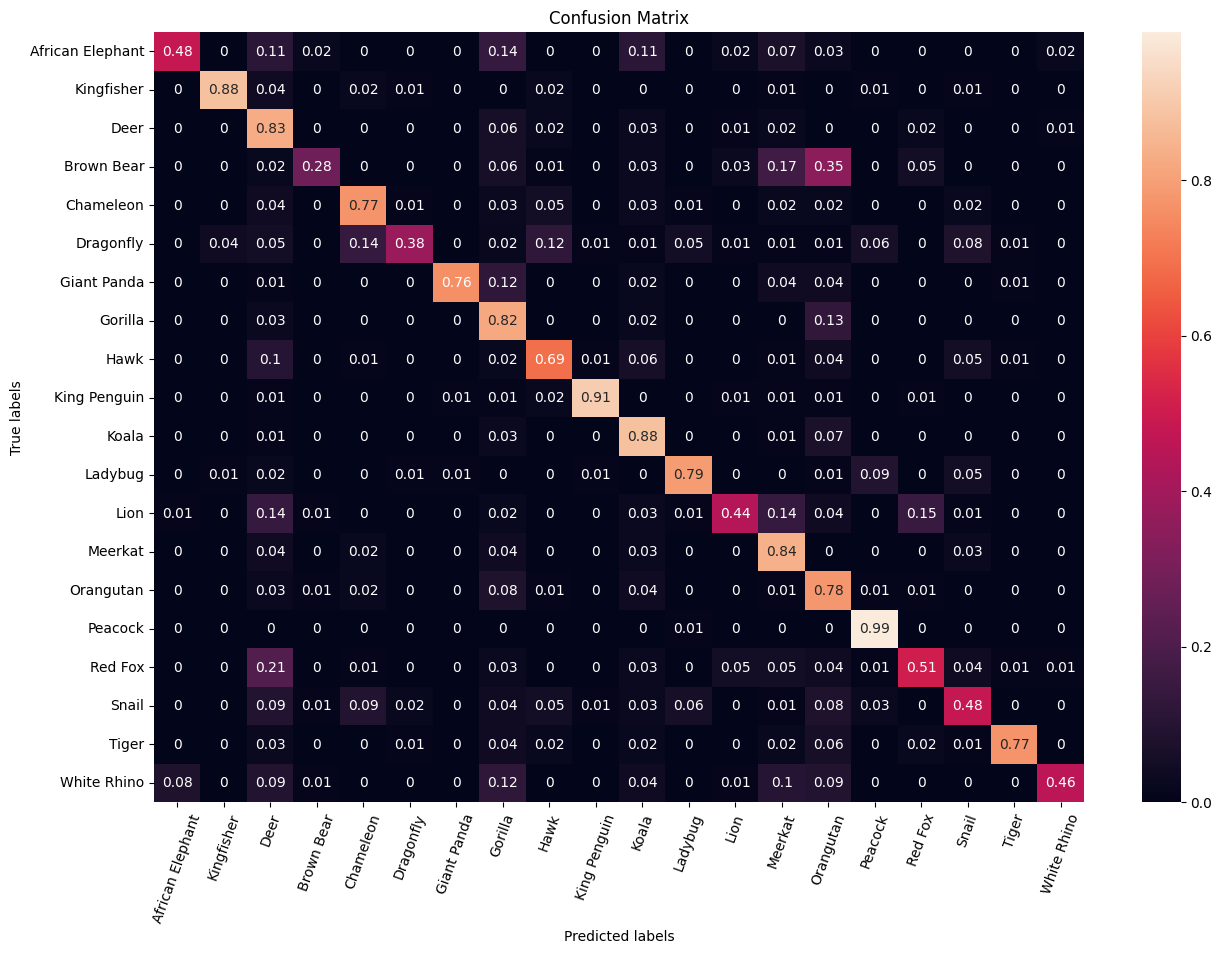

Predicted label ['Orangutan' 'Deer' 'Chameleon' 'Deer' 'Deer' 'Meerkat' 'Deer' 'Red Fox'
 'Deer']
True label ['Snail' 'Snail' 'Snail' 'Snail' 'Tiger' 'Tiger' 'Tiger' 'Tiger' 'Tiger']
Corresponding images are shown below


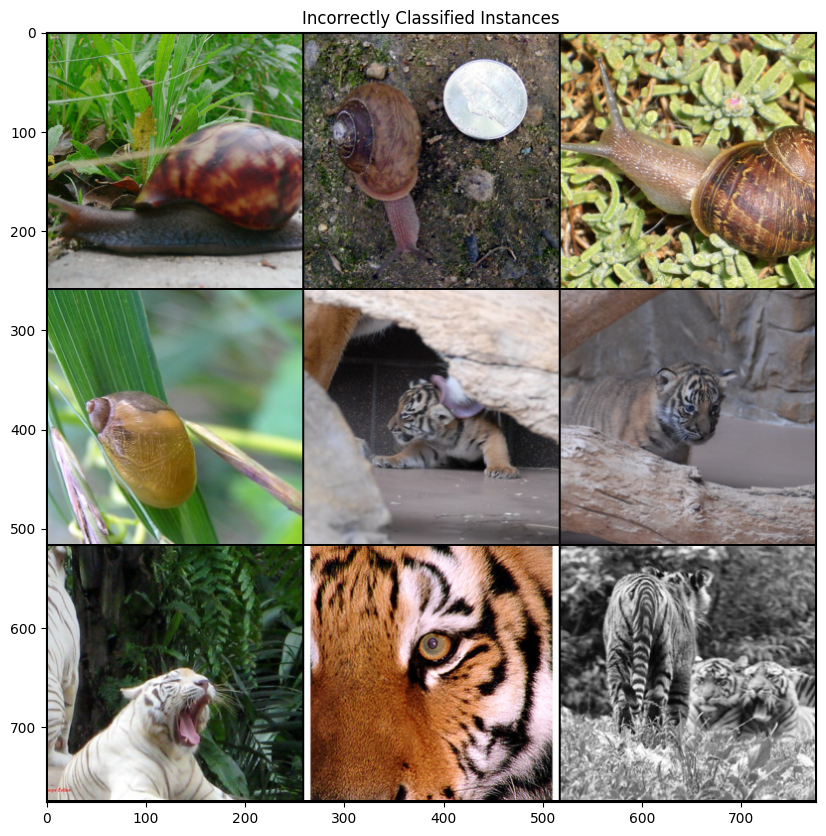

In [50]:
import torch
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

# Assuming MyResNet() is updated with suggested improvements

# Define and train the network
model = MyResNet().to(device)
#change
optimizer = optim.Adamax(model.parameters(), lr=0.00021, weight_decay=3.5824388e-8)
#add
# Decays the learning rate of each parameter group by gamma every step_size epochs
scheduler = StepLR(optimizer, step_size=7, gamma=0.85)

params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))

def train_part(model, optimizer, epochs=1):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        with tqdm(total=len(loader_train), desc=f'Epoch {e+1}/{epochs}', unit='batch') as pbar:
            for t, (x, y) in enumerate(loader_train):
                model.train()  # put model to training mode
                x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
                y = y.to(device=device, dtype=torch.long)

                scores = model(x)
                loss = F.cross_entropy(scores, y)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                pbar.update(1)
                pbar.set_postfix(loss=loss.item())

        # Step the scheduler
        scheduler.step()

        # Check accuracy after each epoch
        check_accuracy(loader_val, model, analysis=False)

train_part(model, optimizer, epochs=15)



# Report test set accuracy
check_accuracy(loader_test, model, analysis=True)  # Assuming loader_test is your test DataLoader

# Save the model
torch.save(model.state_dict(), 'model_improved.pt')


In [27]:
# # define and train the network
# model = MyResNet()
# optimizer = optim.Adamax(model.parameters(), lr=0.0001, weight_decay=1e-7)

# params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print("Total number of parameters is: {}".format(params))

# train_part(model, optimizer, epochs = 10)


# # report test set accuracy
# check_accuracy(loader_val, model, analysis=True)


# # save the model
# torch.save(model.state_dict(), 'model.pt')

---

<!-- BEGIN QUESTION -->

### Network Performance

Run the code below when all engineering decisions have been made, do not overfit to the test set!

**Note that** this will appear in the output, and be checked by markers (so ensure it is present in the auto-export)

Got 1374 / 2000 correct of val set (68.70)
check acc <class 'torch.Tensor'> <class 'torch.Tensor'>


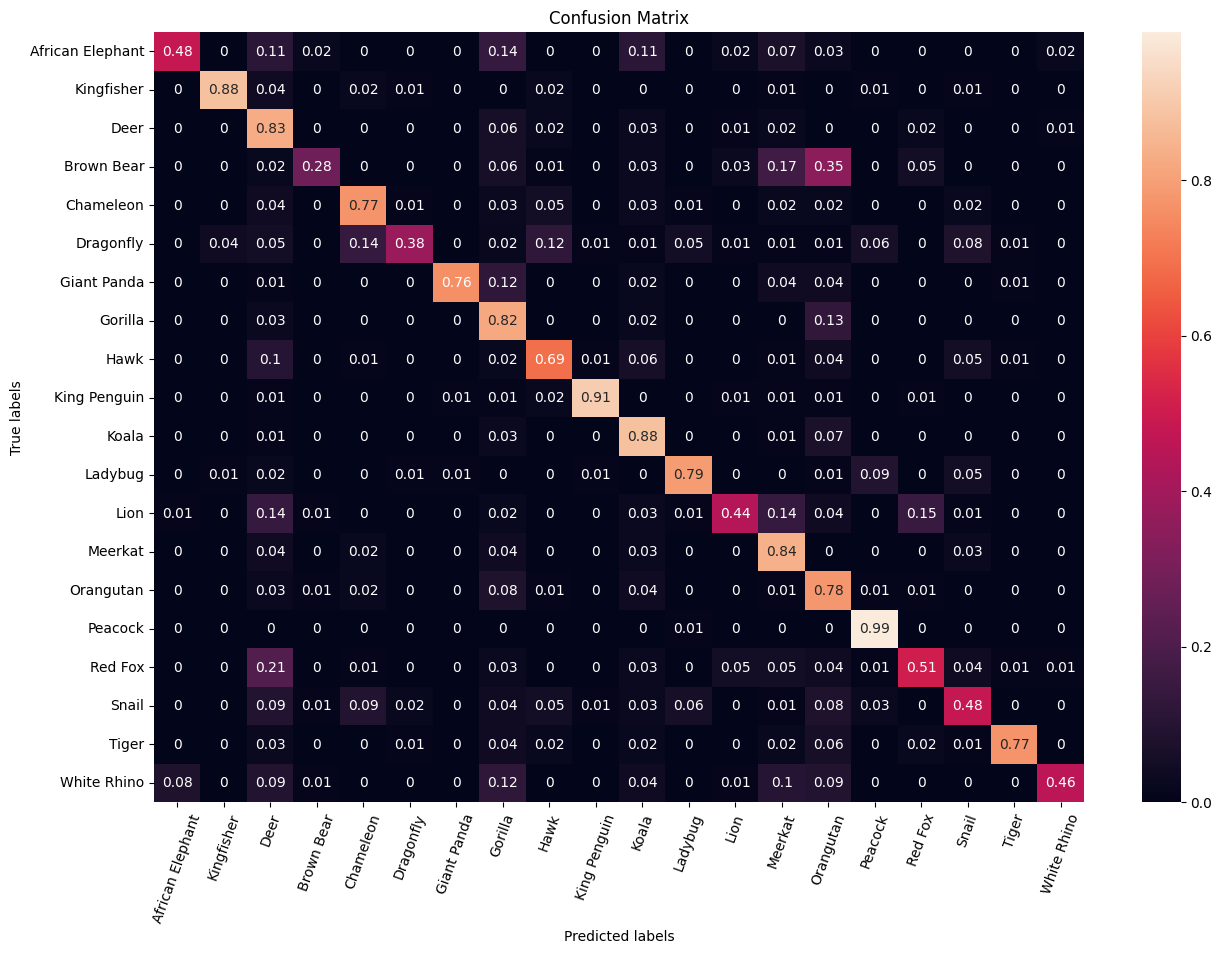

Predicted label ['Orangutan' 'Deer' 'Chameleon' 'Deer' 'Deer' 'Meerkat' 'Deer' 'Red Fox'
 'Deer']
True label ['Snail' 'Snail' 'Snail' 'Snail' 'Tiger' 'Tiger' 'Tiger' 'Tiger' 'Tiger']
Corresponding images are shown below


0.687

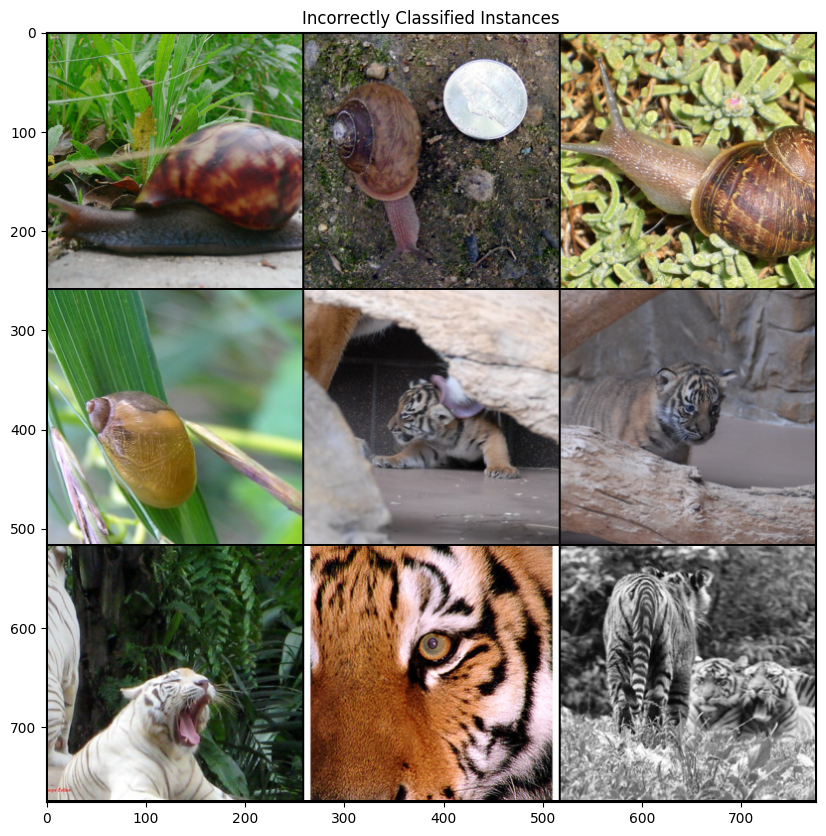

In [52]:
# Run once your have trained your final model
check_accuracy(loader_test, model, analysis=True)

___

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q2.1: Hyperparameter Search:
Given such a network with a large number of trainable parameters, and a training set of a large number of data, what do you think is the best strategy for hyperparameter searching? (3 points)

**Answer:**

For a network with a large number of trainable parameters and a substantial training dataset, Grid Search might be too time-consuming and computationally expensive.

I used strategy that involves two-phase approach: starting with a Random Search followed by a more focused search using the Tree-structured Parzen Estimator (TPE) algorithm. This strategy balances the exploration of the hyperparameter space with the efficiency of exploring the most promising regions identified in the initial search.

This strategy begins with 10 iterations of Random Search to broadly explore the hyperparameter space. This method randomly selects combinations of hyperparameters to evaluate, providing a baseline understanding of the performance landscape. Random Search is more efficient than exhaustive Grid Search, especially in high-dimensional spaces where some hyperparameters have a more significant impact on performance than others. It can quickly identify regions of the hyperparameter space that need further exploration without requiring an exhaustive search of all possible combinations.

After identifying a promising range of hyperparameters with Random Search, I used the TPE algorithm to refine the search. TPE models the probability of achieving better performance based on past results, and it can intelligently sample new hyperparameter combinations from areas with higher probabilities. TPE is more sophisticated and efficient than Random Search for fine-tuning hyperparameters. This approach enhances the initial exploration by guiding computational efforts towards the most promising regions, thus improving the chances of identifying an optimal or near-optimal combination of hyperparameters.

---

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q2.2: Engineering Decisions

Detail which engineering decisions you made to boost the performance of the baseline results. Why do you think that they helped? (7 points)

**Answer:**

I have made several changes to the hyperparameters, model architecture, traning dynamics.etc as shown below:

**1.Data Augmentation**: I used RandomResizedCrop and RandomHorizontalFlip for training set (also tried ColorJitter and GaussianBlur during tuning), which can help the model to generalise better to unseen ddata by increasing the diversity of the training dataset. This method can avoid overfirring, and potentially increase model's performance because it can generalise to variation better during validating and testing.

**2.Learning Rate & Weight Decay & Learning Rate Scheduler**: I slightly increased the learning rate from 0.001 to 0.00021, and imported a smaller weight decay rate. The learning rate is chosen by hyperparameter tuning strategy I mentioned above, and a smaller decay value can present over-penalizing the model's weights.

**3.Incorporation of StepLR Scheduler** I also import a learning rate scheduler StepLR, it can decay the learning rate every 7 epochs by 0.85, reducing it at predefined intervals. This strategy helps in fine-tuning the optimization process by making larger updates in the early stages of training when the potential for improvement is high, and smaller updates later on, preventing overshooting and facilitating convergence to a better local minimum. These combination boosts model's performance from 30% to over 60%.

**4.Increased Epochs**: The number of training epochs increased from 10 to 15, which gives the model to learn better from the provided dataset, especially with the help of weight decay and drop out rate (will mention below). It stops at 15 because I notice there is always a slight dropped accuracy around 14 epochs or 15 epochs, so I preassume this might be a trend of potential overfit. It would be better to stop the model there at 15 epochs. 15 epochs allows adequent time for training and adaptive scheme, but also preserve the reasonable performance.

**5.Increased Initial Channel Size**:I increased from it from 16 to 64.This allow the model to capture a wider range of fearures from the beginning, which has the potential to result in better performance, because the network can start to learn more comolex feature representation in this case.

**6.Replacement of MaxPool with AdaptiveAvgPool2d**: The standard MaxPooling was replaced with Adaptive Average Pooling in the final stages of the ResNet architecture. AdaptiveAvgPool2d dynamically adjusts pooling regions to output a fixed size, facilitating a more flexible and efficient dimensionality reduction. This change likely contributed to better spatial feature extraction and more adaptable integration with the fully connected layers, enhancing the overall model's ability to generalize from spatial features.

**7.Reduced Number of Layers**: The original model was changed from 6 layers to 4, aligning with the ResNet-18 architecture published in paper. This decision was based on ResNet-18's proven effectiveness across various tasks, suggesting that a more compact model can still capture complex features. It also decreases the computational cost and reduces the risk of overfitting. The deeper networks can capture more complex features, but they also require more data and computational resources to train. The reduction in layers likely helped by focusing learning on more relevant features and improving generalization.

**8.Introduction of Dropout**: Dropout layers were added to randomly zero out a fraction of the output units during training. This technique encourages the model to learn more robust and redundant representations of the data by preventing reliance on any single set of features. The introduction of dropout helps in combating overfitting.

**9.Increased Batch Size & Increased Data Workers**: I increased the batch size from 128 to 256, which contributes to the speed of convergence, as the gradient estimates could be more stable.

The number of works for DataLoader also increases from 2 to 8, which facilitates the parallel processing during training, speeding up the process.

---

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q2.3: Out of distribution evaluation

Lets see how your trained model performs when evaluated on cartoons of the 20 animal classes. Do not try and modify your model to perform well on this task, this is just a reflective exercise. How did your model perform at the task? Why do you think this was the case? Detail one method which you expect would improve model performance. (2 points)

In [53]:
ON_COLAB = True

!wget https://zenodo.org/records/10424022/files/cartoons.zip?download=1

if ON_COLAB:
    !unzip /content/cartoons.zip?download=1 > /dev/null

else:
    !unzip cartoons.zip?download=1 > /dev/null

--2024-02-06 15:18:14--  https://zenodo.org/records/10424022/files/cartoons.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.185.79.172, 188.184.103.159, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1737267 (1.7M) [application/octet-stream]
Saving to: ‘cartoons.zip?download=1.1’

cartoons.zip?downlo 100%[===================>]   1.66M  1.65MB/s    in 1.0s    

2024-02-06 15:18:16 (1.65 MB/s) - ‘cartoons.zip?download=1.1’ saved [1737267/1737267]

replace cartoons/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [54]:
mean = torch.Tensor([0.485, 0.456, 0.406]) # assuming same dist as imagenet
std = torch.Tensor([0.229, 0.224, 0.225])
transform = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize(mean.tolist(), std.tolist()),
        ]

    )
cartoon_path = ('/content/' if ON_COLAB else '') + 'cartoons'


cartoon_dataset = datasets.ImageFolder(cartoon_path, transform=transform)

print(len(cartoon_dataset))

batch_size = 128

cartoon_loader = DataLoader(cartoon_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

400


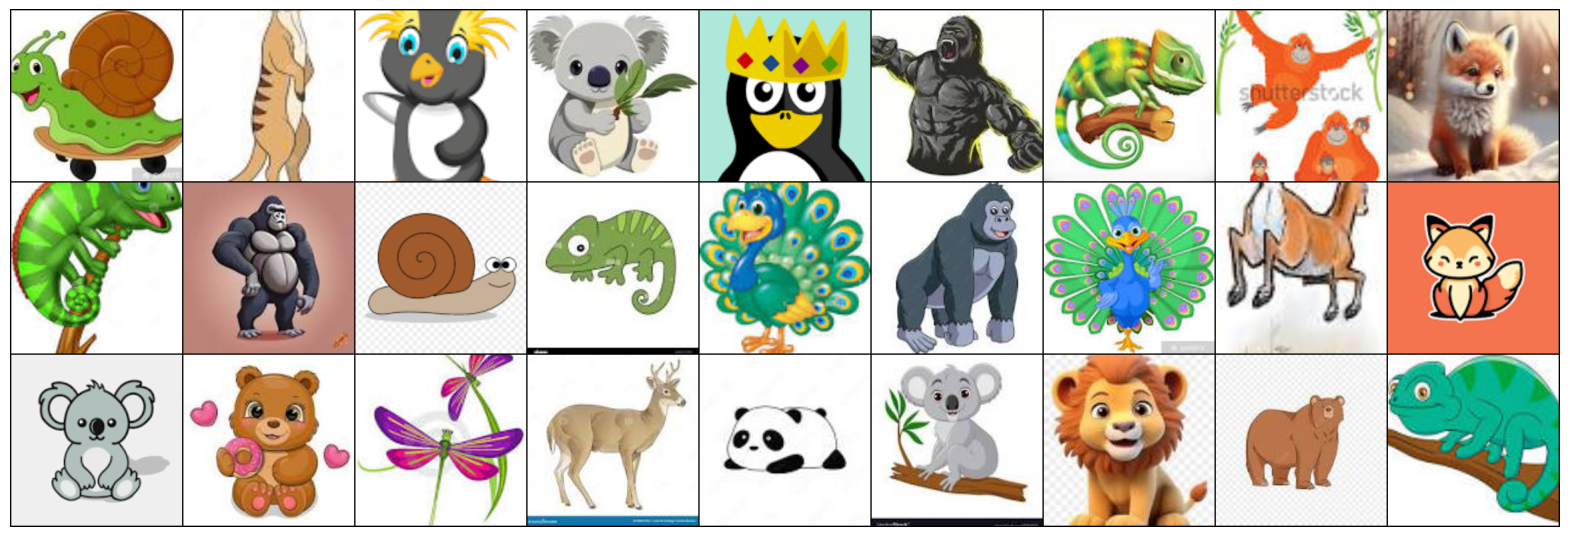

In [55]:
sample_inputs, _ = next(iter(cartoon_loader))
fixed_input = sample_inputs[:27, :, :, :]

img = make_grid(denorm(fixed_input), nrow=9, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)

plt.figure(figsize=(20,10))
plt.axis('off')
show(img)

Got 89 / 400 correct of val set (22.25)
check acc <class 'torch.Tensor'> <class 'torch.Tensor'>


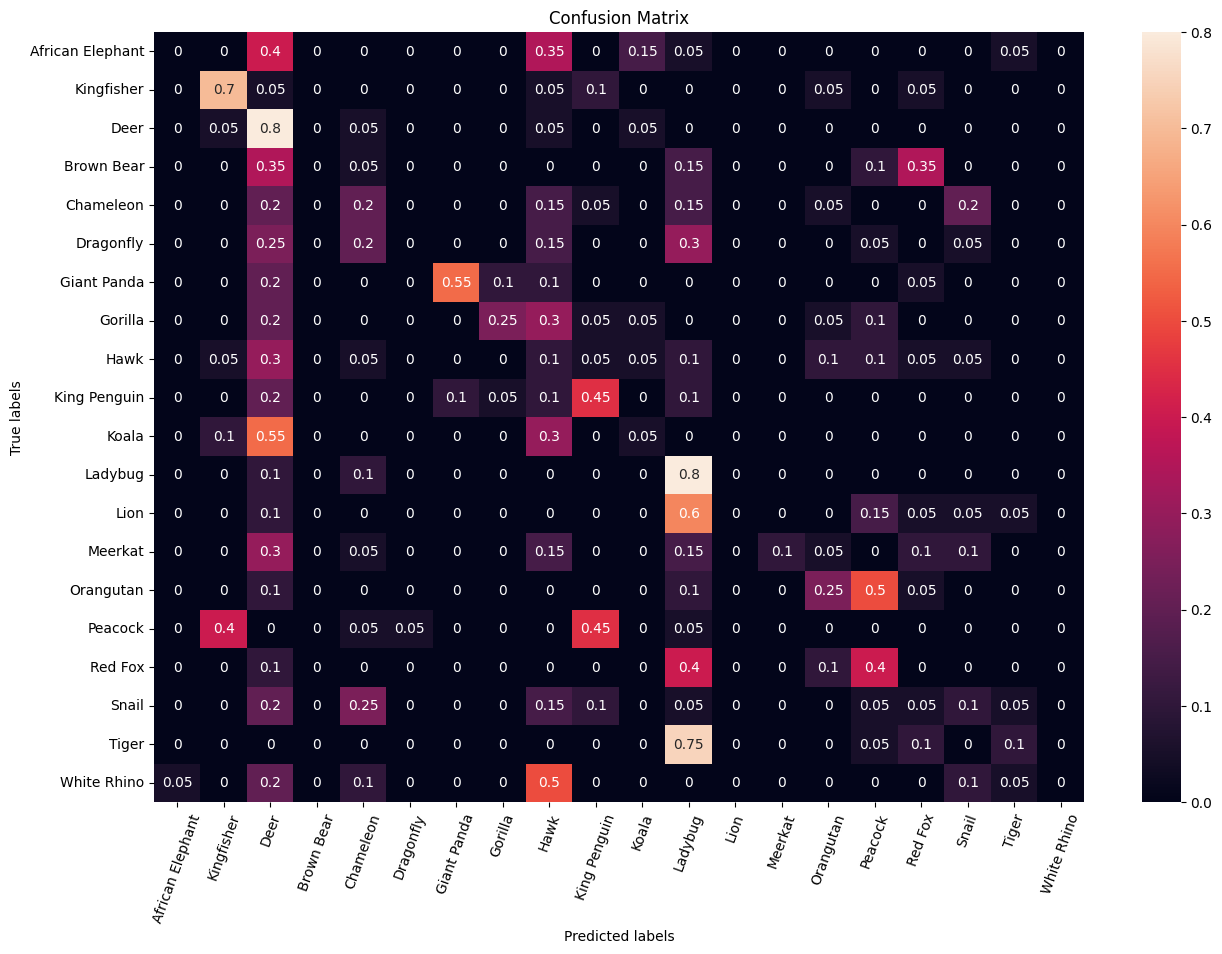

Predicted label ['Ladybug' 'Red Fox' 'King Penguin' 'Peacock' 'Peacock' 'Hawk' 'Peacock'
 'Peacock' 'Hawk']
True label ['Brown Bear' 'Tiger' 'Peacock' 'Lion' 'Orangutan' 'Snail' 'Hawk'
 'Brown Bear' 'Koala']
Corresponding images are shown below


0.2225

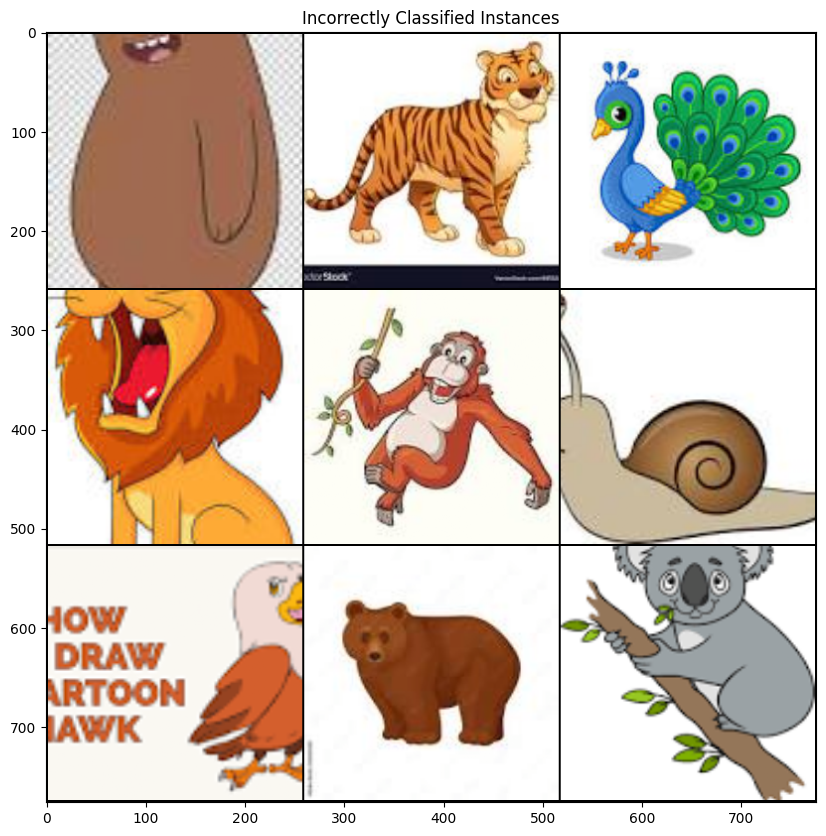

In [56]:
check_accuracy(cartoon_loader, model, analysis=True)

**Answer:**

Evaluating a model trained on real-world animal images on cartoons results in a significant performance drop from 68% to 22%, primarily due to the big differences in feature distributions between real images and their cartoon versions.

Reasons:
1. Cartoons are stylized and abstract representations that often lack the texture, color variance, and detailed features present in real-world images. The model trained on real images learns to recognize patterns and features that are significantly different from those in cartoons

2. Deep learning models can struggle to generalize to unseen data that deviates significantly from their training data. The learned features and representations may not be relevant or sufficient to accurately interpret and classify cartoons.

Solutions:
1. To improve performance on cartoons, one effective approach would be to leverage domain adaptation techniques or transfer learning. This involves adjusting the model trained on real images to better handle the cartoon domain

2. If a small dataset of labeled cartoons is available, I could fine-tune the model on this dataset. This involves continuing the training process of the pre-trained model (on real images) with the cartoon dataset. The process allows the model to adjust its learned features to better accommodate the new domain(cartoon). Even a small amount of cartoon data can be beneficial if used effectively, allowing the model to learn the abstract features and stylizations unique to cartoons.

<!-- END QUESTION -->

## Part 3 (10 points)

The code provided below will allow you to visualise the feature maps computed by different layers of your network. Run the code (install matplotlib if necessary) and **answer the following questions*(:

<!-- BEGIN QUESTION -->

### Q3.1 : Learned Features

Compare the feature maps from low-level layers to high-level layers, what do you observe? (4 points)

**Answer:**

Low level feature maps likely represent initial convolutions that extract edges, textures, and simple patterns. Each map highlights different aspects of the visual input, such as lines and color gradients.The feature maps maintain a high resolution, preserving the detailed structure of the input image. This captures fine details before subsequent pooling layers reduce spatial dimensions.

 In higher layers, the network combines the low-level features to form more complex and abstract representations. These higher-level features are less visually interpretable and more specific to the classes the model is trained to recognize. As we move deeper into the network, spatial resolution decreases due to pooling operations. This reduction in resolution corresponds to an increase in the receptive field, allowing the network to capture more global and abstract features of the input.

 In summary, low-level layers capture basic visual elements that are common across various images, while high-level layers extract more abstract and class-specific features that contribute to the model's decision-making process.

---

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q3.2: Performance Analysis

Use the training log, reported test set accuracy and the feature maps, analyse the performance of your network. If you think the performance is sufficiently good, explain why; if not, what might be the problem and how can you improve the performance? (4 points)

**Answer:**

The training log suggests a consistent improvement in validation accuracy over epochs, indicating that the network is learning effectively from the data. Starting at 39.19% accuracy on the validation set after the first epoch and rising to a peak of 72.32% by the 14th epoch (sometimes the peak is at 13th epoch), the model shows a clear upward trajectory in learning. However, it seems there might be a slight overfitting issue since the accuracy drops slightly in subsequent epochs (14th or 15th). The final reported test set accuracy of 66.30% is a solid outcome but does indicate the room for improvement, given the difference between peak validation accuracy and test set performance.

If the dataset has an imbalance, techniques like weighted loss functions can provide a counterbalance, ensuring the model does not favor more common classes over rarer ones. Also The initial layers of the model might not be extracting the most beneficial features for distinguishing between certain classes. Experimenting with different architectures or pre-trained models could yield improvements.

Further augmentation could help the model generalize better, especially for classes with lower performance.

The current model is still not complex enough, and the high-level featurees can be more abstract (just pixels), adding more layers to further process could be a better idea.

---

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q3.3: Alternative Evaluations

What are the other possible ways to analyse the performance of your network? (2 points)

**Answer:**

1. Qualitative Analysis.
This involves visually inspecting the outputs of the model to understand its decisions. For example, in image classification tasks, one can look at the correctly and incorrectly classified images to identify patterns or common characteristics that lead to errors. This might involve checking if misclassifications happen within similar classes, which could suggest that the model struggles with specific features.

2. F1 Score & Confusion Matrix.
For datasets where some classes are underrepresented, accuracy alone might not reflect the model's performance accurately, as the model could simply predict the majority class most of the time. F1 score gives statistical overview of the model performance.

  Confusion Matrix plays the similar roles, but it gives a more direct overview of the data distribution, and class-wise performance.

---

<!-- END QUESTION -->

**Feature Visualization**

The code below will visualize the features of your network layers (you may need to modify the layer names if you made changes to your architecture).

If you change the plotting code, please ensure it still exports correctly when running the submission cell.

In [57]:
import matplotlib.pyplot as plt

def plot_model_features():
    fig = plt.tight_layout()
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    vis_labels = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4']

    for l in vis_labels:
        getattr(model, l).register_forward_hook(get_activation(l))


    data, _ = test_dataset[112]
    data = data.unsqueeze_(0).to(device = device, dtype = dtype)
    output = model(data)

    for idx, l in enumerate(vis_labels):
        act = activation[l].squeeze()

        # only showing the first 16 channels
        ncols, nrows = 8, 2

        fig, axarr = plt.subplots(nrows, ncols, figsize=(15,5))
        fig.suptitle(l)

        count = 0
        for i in range(nrows):
            for j in range(ncols):
                axarr[i, j].imshow(act[count].cpu())
                axarr[i, j].axis('off')
                count += 1

<!-- BEGIN QUESTION -->



<Figure size 640x480 with 0 Axes>

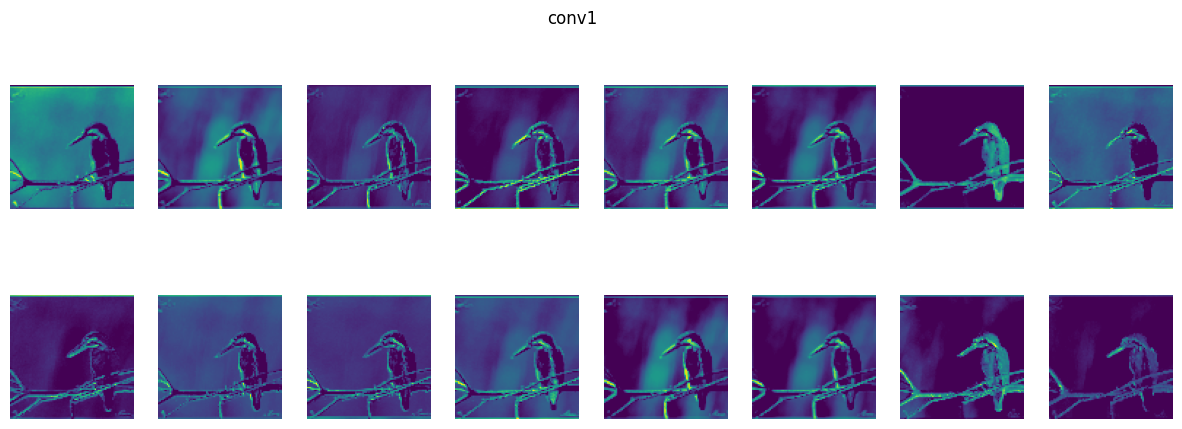

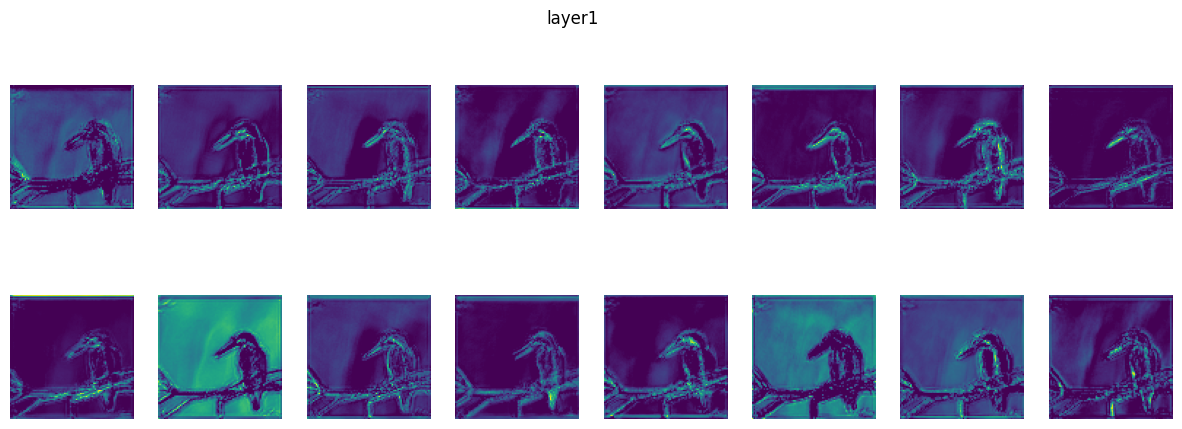

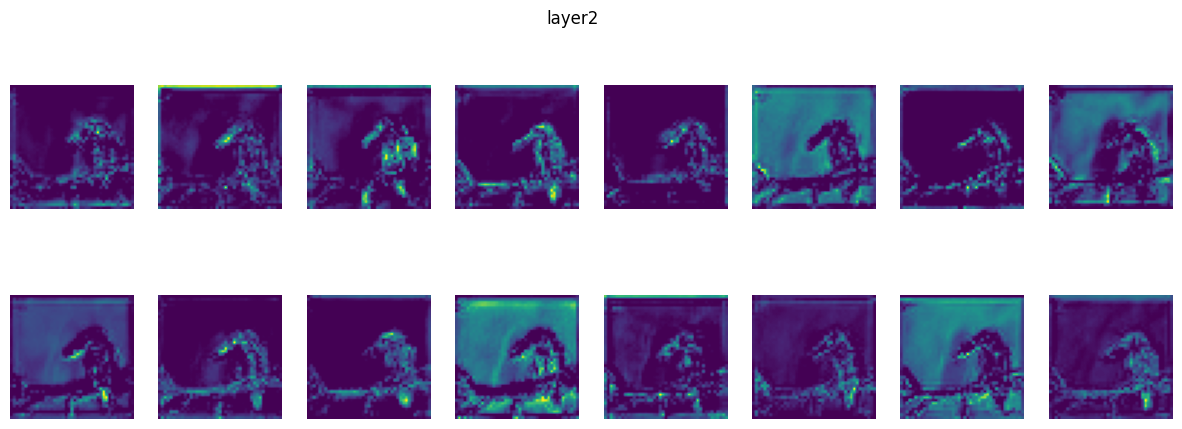

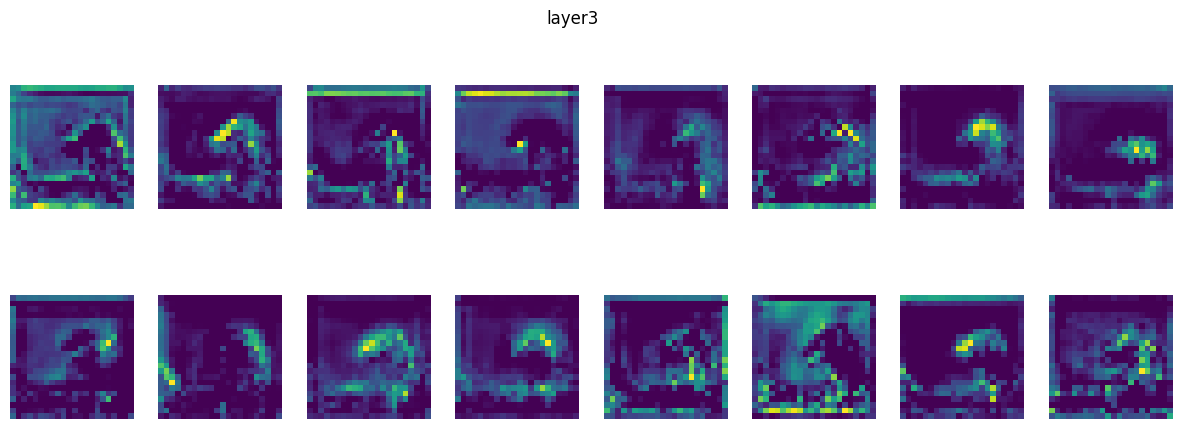

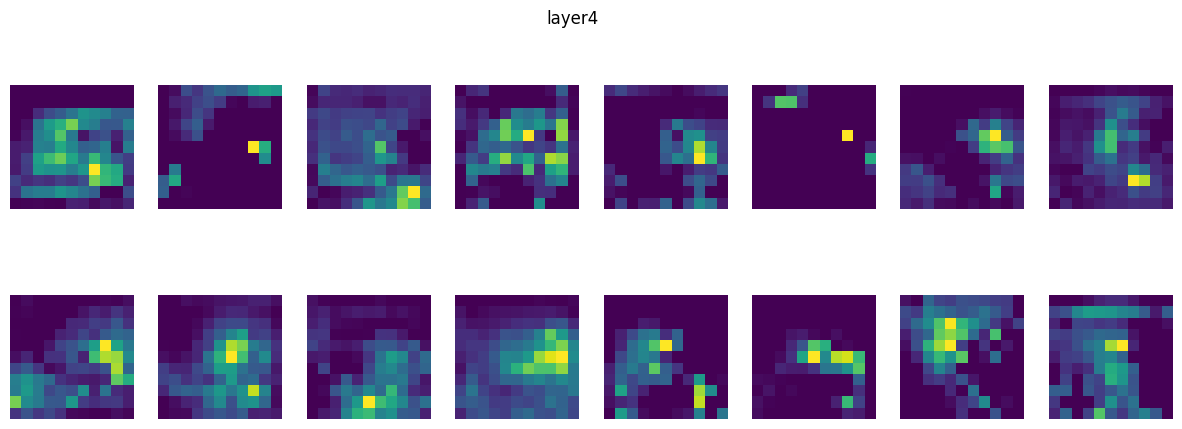

In [58]:
# Visualize the figure here, so it is exported nicely
plot_model_features()

<!-- END QUESTION -->

## Submission
Git push your finalized version of this notebook (with saved outputs) to the gitlab repo which you were assigned. You should request our tests once and check that the ```preview.pdf```:
* Passes all public tests (these are the same ones provided / embedded in the notebook itself)
* Contains your qualitative answers
* Contains your figures (confusion matrix and network features)

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [62]:
grader.check_all()

BatchNorm Layer results: All test cases passed!
BatchNorm Layer - 1 message: Shape Test Passed
BatchNorm Layer - 2 message: Type Test Passed
BatchNorm Layer - 3 message: Param Name Test Passed
BatchNorm Layer - 4 message: Param Shape Test Passed

Convolution Layer results: All test cases passed!
Convolution Layer - 1 message: Shape Test Passed
Convolution Layer - 2 message: Type Test Passed
Convolution Layer - 3 message: Param Name Test Passed
Convolution Layer - 4 message: Param Shape Test Passed

Linear Layer results: All test cases passed!
Linear Layer - 1 message: Shape Test Passed
Linear Layer - 2 message: Type Test Passed
Linear Layer - 3 message: Param Name Test Passed
Linear Layer - 4 message: Param Shape Test Passed

MaxPool Layer results: All test cases passed!
MaxPool Layer - 1 message: Shape Test Passed
MaxPool Layer - 2 message: Type Test Passed